<a href="https://colab.research.google.com/github/hoangtrung1801/study-deep-learning/blob/main/violence_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install tpdm
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached remotezip-0.12.1.tar.gz (7.5 kB)
  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement tpdm (from versions: none)
ERROR: No matching distribution found for tpdm
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
!pip install remotezip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached remotezip-0.12.1.tar.gz (7.5 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for remotezip: filename=remotezip-0.12.1-py3-none-any.whl size=7933 sha256=7afa8224a5b78df71c737e95ae1cff7385b40b877ae25f14866c94f337e55efb
  Stored in directory: /root/.cache/pip/wheels/fc/76/04/beed1a6df4eb7430ee13c3900746edd517e5e597298d1f73f3
Successfully built remotezip


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hoangtrung1801","key":"52486fad593276d02fe2ebad141f65bd"}'}

In [3]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [4]:
!kaggle datasets download -d yassershrief/hockey-fight-vidoes

100% 163M/164M [00:09<00:00, 20.2MB/s]
100% 164M/164M [00:09<00:00, 18.9MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('/content/hockey-fight-vidoes.zip', 'r') as files:
  files.printdir()

In [ ]:
!unzip ./hockey-fight-vidoes.zip

In [88]:
import tqdm
import random
import pathlib
import itertools
import collections
import sys
import os
import cv2
import numpy as np
import remotezip as rz
import matplotlib.pyplot as plt
from random import shuffle

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation

import h5py

In [54]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [14]:
# Frame size
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 2

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 20

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".avi"

In [15]:
data_path = './data'

In [21]:
def get_frames(data_dir, file_name):
  file_path = os.path.join(data_dir, file_name)
  if not os.path.exists(file_path):
    return
  print(file_path)
  images = []
  capture = cv2.VideoCapture(file_path)
  success, image = capture.read()
  count = 0
  while count < _images_per_file:
    rgb_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    res = cv2.resize(rgb_image, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
    images.append(res)
    success, image = capture.read()
    count += 1
  result = np.array(images)
  result = (result / 255).astype(np.float16)
  return result

In [22]:
def label_video_names(in_dir):

    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []


    for current_dir, dir_names,file_names in os.walk(in_dir):

        for file_name in file_names:

            if file_name[0:2] == 'fi':
                labels.append([1,0])
                names.append(file_name)
            elif file_name[0:2] == 'no':
                labels.append([0,1])
                names.append(file_name)


    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    shuffle(c)

    names, labels = zip(*c)

    return names, labels

In [23]:
names, labels = label_video_names(data_path)

In [28]:
names[0]

'no28_xvid.avi'

In [24]:
frames = get_frames(data_path, names[0])

./data/no28_xvid.avi


In [25]:
visible_frames = (frames*255).astype('uint8')

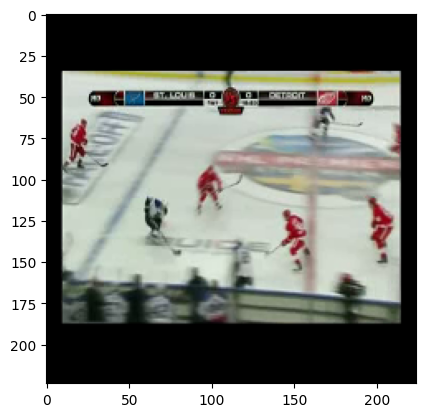

In [26]:
plt.imshow(visible_frames[1])

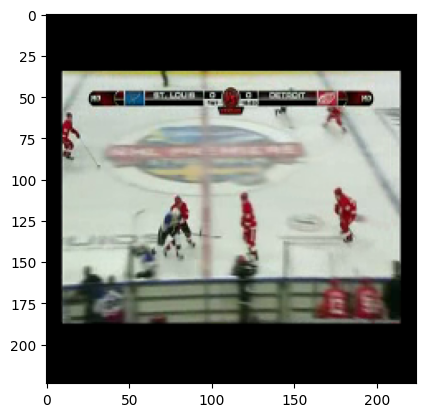

In [27]:
plt.imshow(visible_frames[15])

In [30]:
image_model = VGG16(include_top=True, weights='imagenet')

553467096/553467096 [==============================] - 25s 0us/step


In [36]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [42]:
# We will use the output of the layer prior to the final
# classification-layer which is named fc2. This is a fully-connected (or dense) layer.
transfer_layer = image_model.get_layer('fc2')

image_model_transfer = tf.keras.models.Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = tf.keras.backend.int_shape(transfer_layer.output)[1]


print("The input of the VGG16 net have dimensions:",tf.keras.backend.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of VGG16 net have dimensions: ", transfer_values_size)

The input of the VGG16 net have dimensions: (224, 224)
The output of the selecter layer of VGG16 net have dimensions:  4096


In [43]:
def get_transfer_values(current_dir, file_name):

    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)

    image_batch = np.zeros(shape=shape, dtype=np.float16)

    image_batch = get_frames(current_dir, file_name)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)

    return transfer_values

In [46]:
val = get_transfer_values(data_path, names[0])

./data/no28_xvid.avi
1/1 [==============================] - 0s 42ms/step


In [52]:
def process_transfer(vid_names, in_dir, labels):

    count = 0

    tam = len(vid_names)

    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)

    while count<tam:

        video_name = vid_names[count]

        image_batch = np.zeros(shape=shape, dtype=np.float16)

        image_batch = get_frames(in_dir, video_name)

         # Note that we use 16-bit floating-points to save memory.
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)

        transfer_values = \
            image_model_transfer.predict(image_batch)

        labels1 = labels[count]

        aux = np.ones([20,2])

        labelss = labels1*aux

        yield transfer_values, labelss

        count+=1

In [55]:
def make_files(n_files):

    gen = process_transfer(names_training, data_path, labels_training)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]

    with h5py.File('prueba.h5', 'w') as f:

        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]


        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)

        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)

         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:

            if numer == n_files:

                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]

            print_progress(numer, n_files)

            numer += 1

In [72]:
def make_files_test(n_files):

    gen = process_transfer(names_test, data_path, labels_test)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]

    with h5py.File('pruebavalidation.h5', 'w') as f:

        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]


        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)

        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)

         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:

            if numer == n_files:

                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]

            print_progress(numer, n_files)

            numer += 1

In [57]:
training_set = int(len(names)*0.8)
test_set = int(len(names)*0.2)

names_training = names[0:training_set]
names_test = names[training_set:]

labels_training = labels[0:training_set]
labels_test = labels[training_set:]

In [ ]:
make_files(training_set)

In [ ]:
make_files_test(test_set)

In [82]:
def process_alldata_training():

    joint_transfer=[]
    frames_num=20
    count = 0

    with h5py.File('prueba.h5', 'r') as f:

        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc

    data =[]
    target=[]

    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))

    return data, target

In [83]:
def process_alldata_test():

    joint_transfer=[]
    frames_num=20
    count = 0

    with h5py.File('pruebavalidation.h5', 'r') as f:

        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc

    data =[]
    target=[]

    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))

    return data, target

In [84]:
data, target = process_alldata_training()

In [85]:
data_test, target_test = process_alldata_test()

In [89]:
chunk_size = 4096
n_chunks = 20
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

In [90]:
epoch = 100
batchS = 500

history = model.fit(np.array(data[0:720]), np.array(target[0:720]), epochs=epoch,
                    validation_data=(np.array(data[720:]), np.array(target[720:])),
                    batch_size=batchS, verbose=2)

Epoch 1/100
2/2 - 6s - loss: 0.2985 - accuracy: 0.4931 - val_loss: 0.2232 - val_accuracy: 0.6875 - 6s/epoch - 3s/step
Epoch 2/100
2/2 - 0s - loss: 0.2756 - accuracy: 0.4597 - val_loss: 0.3364 - val_accuracy: 0.3125 - 445ms/epoch - 222ms/step
Epoch 3/100
2/2 - 0s - loss: 0.2627 - accuracy: 0.5153 - val_loss: 0.2355 - val_accuracy: 0.6875 - 453ms/epoch - 226ms/step
Epoch 4/100
2/2 - 0s - loss: 0.2527 - accuracy: 0.4847 - val_loss: 0.2241 - val_accuracy: 0.6875 - 435ms/epoch - 217ms/step
Epoch 5/100
2/2 - 0s - loss: 0.2545 - accuracy: 0.4847 - val_loss: 0.2480 - val_accuracy: 0.7375 - 468ms/epoch - 234ms/step
Epoch 6/100
2/2 - 0s - loss: 0.2472 - accuracy: 0.7208 - val_loss: 0.2780 - val_accuracy: 0.3125 - 457ms/epoch - 229ms/step
Epoch 7/100
2/2 - 0s - loss: 0.2496 - accuracy: 0.5153 - val_loss: 0.2718 - val_accuracy: 0.3125 - 495ms/epoch - 247ms/step
Epoch 8/100
2/2 - 0s - loss: 0.2468 - accuracy: 0.5153 - val_loss: 0.2476 - val_accuracy: 0.4250 - 393ms/epoch - 196ms/step
Epoch 9/100
2/

In [91]:
result = model.evaluate(np.array(data_test), np.array(target_test))

7/7 [==============================] - 0s 18ms/step - loss: 0.0462 - accuracy: 0.9450


In [92]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.046233125030994415
accuracy 0.9449999928474426


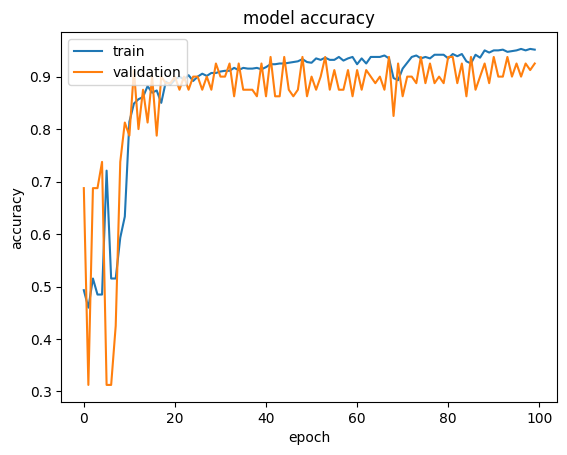

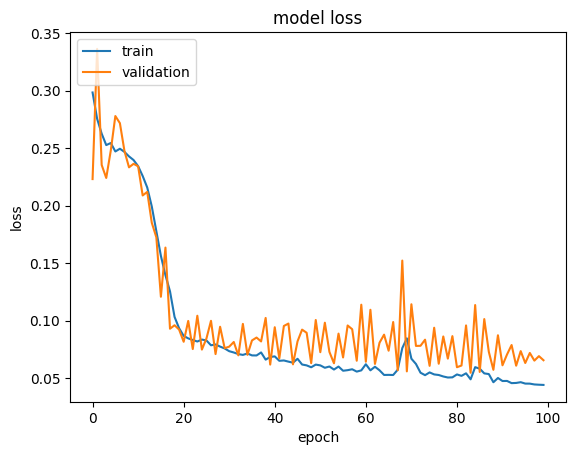

In [93]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()